# Training a Multilayer Perceptron (MLP) in the Collimator Environment


Multilayer Perceptrons (MLPs), a class of feedforward artificial neural networks, stand at the core of deep learning. Comprising multiple layers of nodes in a directed graph, with each layer fully connected to the next, MLPs embody the simple yet powerful architecture for approximating complex functions. 

MLPs are versatile in their applications, ranging from simple tasks like linear regression to complex challenges in image recognition, natural language processing, and beyond. Their ability to learn non-linear relationships and patterns from data makes them invaluable in various fields including finance for predicting stock prices, healthcare for diagnosing diseases from medical images, and technology for powering voice recognition systems.

### Key Features:
- **Function Approximation:** At their heart, MLPs are universal function approximators. Given enough data and computational resources, they can learn to approximate an unknown function that maps any set of inputs to outputs.
- **Classification and Regression:** MLPs are adept at both classification, where they predict discrete labels, and regression, where they forecast continuous quantities.
- **Flexibility and Scalability:** The architecture of MLPs can be easily adjusted to suit the complexity of the task at hand. By modifying the number of layers and nodes, MLPs can be scaled to improve their learning capacity.


In this  Notebook, we will demonstrate how to configure and train an MLP in Collimator.

## Import Necessary Libraries
Let's start by importing all the necessary libraries. We'll need `matplotlib` for plotting, `jax` and `equinox` for model definition and training, `optax` for optimization, and `collimator` for simulation. Additionally, we use `sklearn` to generate and split our dataset.

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

import collimator
from collimator.library import MLP

from sklearn.datasets import make_regression # to make dataset
from sklearn.model_selection import train_test_split

CI = os.getenv("CI") == "true"

%load_ext autoreload
%autoreload 2

## Preparing the Dataset
For this demonstration, we'll create a synthetic regression dataset using scikit-learn's `make_regression` function. This dataset will then be split into training and testing sets to evaluate our model's performance.

In [2]:
n_samples = 500
n_input_features = 4
n_output_features = 2

# Generate data from sklearn's make_regression
X, Y = make_regression(n_samples, n_input_features, n_targets=n_output_features, noise=10.0, random_state=42)

# split data into test and train
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state=84)

print(f"{train_x.shape=}")
print(f"{train_y.shape=}")

train_x.shape=(375, 4)
train_y.shape=(375, 2)


## Collimator MLP block configuration and initialization

The MLP block in Collimator is based on the MLP implementation in the [equinox](https://docs.kidger.site/equinox/api/nn/mlp/) library. As such, the configuration parmameters closely follow the `equinox` implementation.

Here, we define the structure and configuration of our MLP model. We then create an instance of the model (the MLP block) with the specified configuration. This model will be used for both training and prediction.

In [3]:
n_hidden_features=4
n_hidden_layers=2

config = {
    "in_size":n_input_features,
    "out_size":n_output_features,
    "width_size":n_hidden_features,
    "depth":n_hidden_layers,
    "activation_str":"sigmoid",
    "seed": 42,
}

model = MLP(**config)

### Create a function to evaluate MLP with a given input and  MLP parameters

For training and prediction, it is imperative to create custom functions that can evaluate our MLP model given an input `x` and the trainable MLP parameters `mlp_params`. To achieve this, we first create a `base_context` for the MLP block created above. We do this by arbitrarily fixing the input port of the block. In this `base_context`, the initialized parameters of the MLP block (generated through the provided `seed`) will be represented. Subsequently, in the `evaluate_model` function, when a new input `x` and a new set of `mlp_params` is available, we update the `base_context` with the new `mlp_params`, fix the input port to the new input `x` and evaluate the block's output port.

In [4]:
# create a base context that can be modified later
with model.input_ports[0].fixed(jnp.zeros(n_input_features)):
    base_context = model.create_context()

# Function to evaluate the output of the MLP given MLP params and input x
def evaluate_model(x, mlp_params, base_context):
    context = base_context.with_parameter("mlp_params", mlp_params)
    with model.input_ports[0].fixed(x):
        y = model.output_ports[0].eval(context)
    return y

## Visualise prediction from initial MLP parameters
Before training, it's insightful to visualize the model's predictions with its initial parameters. This gives us a baseline performance indicator.

pred_y_train.shape=(375, 2)
pred_y_test.shape=(125, 2)


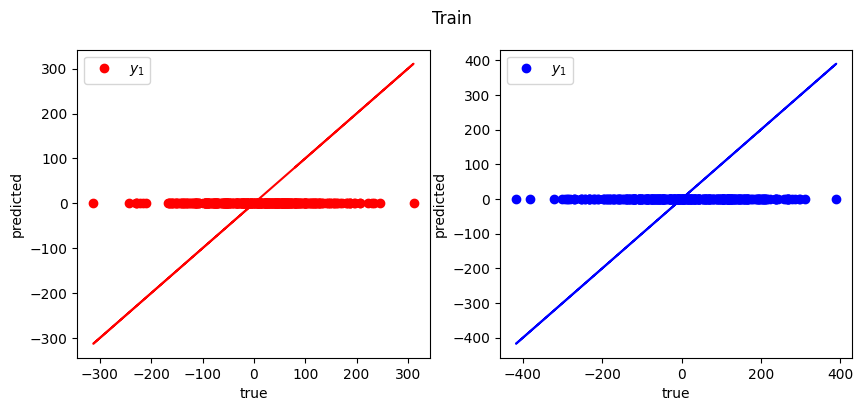

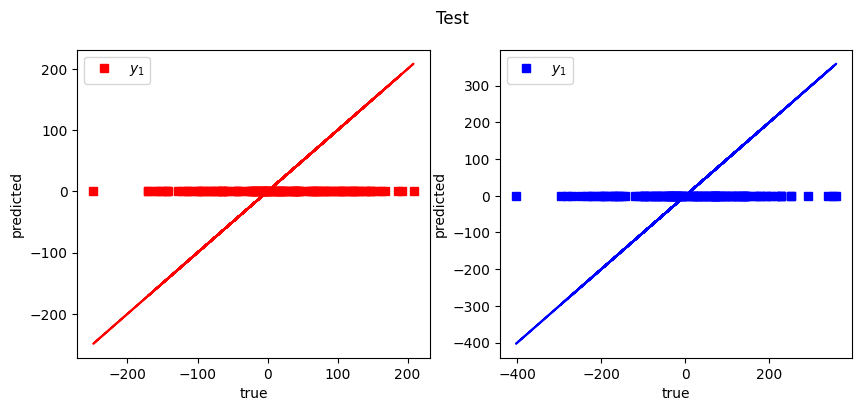

In [5]:
# Extract the mlp parameters from the block
initial_mlp_parameters, _ = eqx.partition(model.mlp, eqx.is_array)

# Predict for training set
pred_y_train = jax.vmap(evaluate_model, in_axes=(0,None,None))(train_x, initial_mlp_parameters, base_context)
print(f"{pred_y_train.shape=}")

# Predict for test set
pred_y_test = jax.vmap(evaluate_model, in_axes=(0,None,None))(test_x, initial_mlp_parameters, base_context)
print(f"{pred_y_test.shape=}")

def plot_predictions(pred_y, dataset="test"):
    if dataset=="train":
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
        ax1.plot(train_y[:,0], pred_y[:,0], 'ro', label=r"$y_1$")
        ax1.plot(train_y[:,0], train_y[:,0], '-r')
        ax2.plot(train_y[:,1], pred_y[:,1], 'bo', label=r"$y_1$")
        ax2.plot(train_y[:,1], train_y[:,1], '-b')
        fig.suptitle("Train")
    elif dataset=="test":
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
        ax1.plot(test_y[:,0], pred_y[:,0], 'rs', label=r"$y_1$")
        ax1.plot(test_y[:,0], test_y[:,0], '-r')
        ax2.plot(test_y[:,1], pred_y[:,1], 'bs', label=r"$y_1$")
        ax2.plot(test_y[:,1], test_y[:,1], '-b')
        fig.suptitle("Test")
    else:
        raise ValueError("Invalid dataset")

    for ax in (ax1, ax2):
        ax.set_xlabel("true")
        ax.set_ylabel("predicted")
        ax.legend()

    plt.show()

plot_predictions(pred_y_train, dataset="train")
plot_predictions(pred_y_test, dataset="test")

## Train the network
In this section, we define the training loop with a mean-squared loss. We leverage JAX's JIT compilation and automatic differentiation capabilities to for efficiency and gradient computation. The `optax` library provides the optimization algorithm, specifically Adam in this case.

Epoch [1000/15000]: loss = 5153.295636855661
Epoch [2000/15000]: loss = 2476.6362170237358
Epoch [3000/15000]: loss = 1254.3325525151122
Epoch [4000/15000]: loss = 696.8085598015949
Epoch [5000/15000]: loss = 432.05749962169375
Epoch [6000/15000]: loss = 299.5960969103968
Epoch [7000/15000]: loss = 225.96171675626798
Epoch [8000/15000]: loss = 186.5162618508093
Epoch [9000/15000]: loss = 160.717046408875
Epoch [10000/15000]: loss = 134.80773574818318
Epoch [11000/15000]: loss = 127.58876189583854
Epoch [12000/15000]: loss = 117.58317482512149
Epoch [13000/15000]: loss = 115.15666675375867
Epoch [14000/15000]: loss = 110.9481214032689
Epoch [15000/15000]: loss = 108.88006305382363


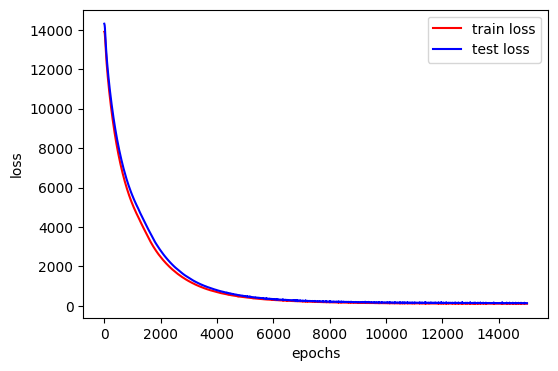

In [6]:
num_epochs = 15000 if not CI else 10

evaluate_model_vmapped = jax.vmap(evaluate_model, in_axes=(0,None,None))

@jax.jit
def loss(mlp_params_flat, train_x, train_y, base_context):
    pred_y = evaluate_model_vmapped(train_x, mlp_params_flat, base_context)
    return jnp.mean((pred_y - train_y)**2)

value_and_grad = jax.jit(jax.value_and_grad(loss))

# Optax optimizer
optimizer = optax.adam(learning_rate=0.05)

# Initialize optimizer state
params = initial_mlp_parameters
opt_state = optimizer.init(params)

train_loss_history = []
test_loss_history = []
for epoch in range(num_epochs):
    train_loss, grads = value_and_grad(params, train_x, train_y, base_context)
    test_loss = loss(params, test_x, test_y, base_context)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    # Print the function value at the current parameters
    if (epoch + 1) % 1000 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: loss = {train_loss}"
        )

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(train_loss_history, "-r", label="train loss")
ax.plot(test_loss_history, "-b", label="test loss")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()

## Assess performance
After training, we evaluate our model on both the training and testing sets to see the improvement and to check for overfitting.

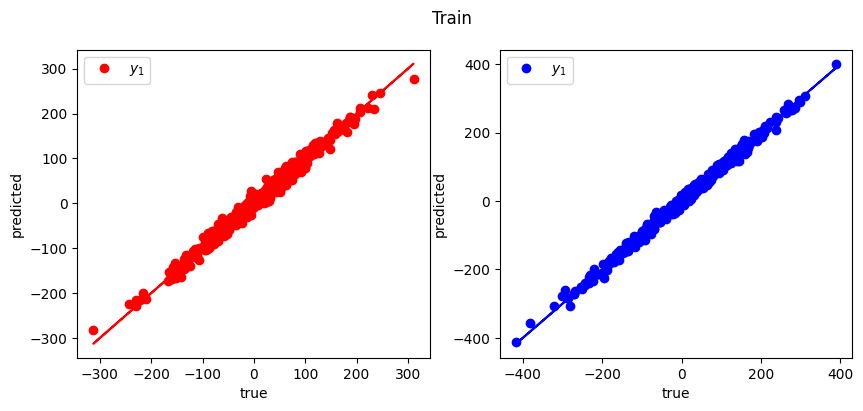

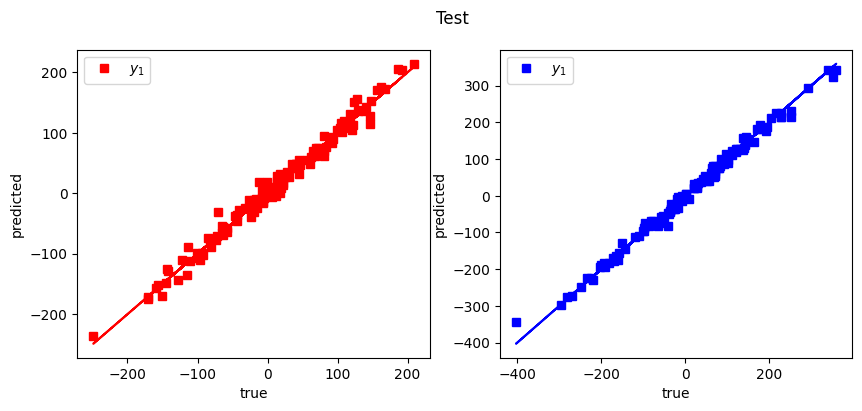

In [7]:
pred_y_train = jax.vmap(evaluate_model, in_axes=(0,None,None))(train_x, params, base_context)
pred_y_test = jax.vmap(evaluate_model, in_axes=(0,None,None))(test_x, params, base_context)

plot_predictions(pred_y_train, dataset="train")
plot_predictions(pred_y_test, dataset="test")

## Save serialized model to use trained model in Collimator GUI

Finally, we demonstrate how to save the trained model parameters for later use and how to load them back into a model. Collimator provides a `serialize` utility to achieve this. This is particularly useful if you want to train an MLP model in Python/Jupyter environment and then want to use the trained model in Collimator GUI.

In [8]:
import tempfile

file_name = f"{tempfile.gettempdir()}/saved_mlp.eqx"
model.serialize(file_name, params)

## Load model and make predictions again

Finally, the code below demonstrates how the saved file can be reloaded.

In [9]:
config = {
    "in_size":n_input_features,
    "out_size":n_output_features,
    "width_size":n_hidden_features,
    "depth":n_hidden_layers,
    "activation_str":"sigmoid",
    "file_name": file_name,
}

loaded_model = MLP(**config)

# create a base context that can be modified
with loaded_model.input_ports[0].fixed(jnp.zeros(n_input_features)):
    base_context_loaded = loaded_model.create_context()

# Function to evaluate the output of the MLP given input x (base context with params does not need to be updated)
def evaluate_loaded_model(x, base_context_loaded):
    with loaded_model.input_ports[0].fixed(x):
        y = loaded_model.output_ports[0].eval(base_context_loaded)
    return y

In [10]:
pred_y_train_loaded = jax.vmap(evaluate_loaded_model, in_axes=(0,None))(train_x, base_context_loaded)
pred_y_test_loaded = jax.vmap(evaluate_loaded_model, in_axes=(0,None))(test_x, base_context_loaded)

assert jnp.allclose(pred_y_train, pred_y_train_loaded)
assert jnp.allclose(pred_y_test, pred_y_test_loaded)